# ノート 6: 畳み込み

### 目標: 畳み込みについて理解を深め、実際に実行してみる

### 背景

畳み込みニューラルネットワーク（CNN）は非常に強力な ML モデルでありスケールの大きなパターンから小さなパターン、多次元のデータまで様々に適用できます。
CNN を学ぶ前に畳み込み（Convolution）について理解しましょう。
ややとっつきにくく感じるかもしれませんが、ML にとって非常に強力な手法です。ぜひ理解するようにしましょう。


### Step 1: インポート


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # 不要な警告の抑止

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

print(f"NumPy  : {np.__version__}")
print(f"Pandas : {pd.__version__}")
print(f"PyTorch: {torch.__version__}")

# 再現性のため乱数を固定
_ = torch.manual_seed(42)

# jupyterのカスタマイズ
%config InlineBackend.figure_format = 'retina'

NumPy  : 1.26.3
Pandas : 2.2.0
PyTorch: 2.1.2+cpu


### Step 2: データの読み込み

このノートでは論文の図 3, 4 で例として示した [Lagerquist et al.(2020)](https://doi.org/10.1175/MWR-D-19-0372.1) のデータからフックパターンのエコー画像を使います。
使いやすいようにフックパターンが明瞭な画像を一つ取り出してあります。


In [2]:
ds_sample = xr.open_dataset(
    "../datasets/lagerquist_2020/lagerquist_storm_example.nc", engine="netcdf4"
)

print(ds_sample)

<xarray.Dataset>
Dimensions:             (grid_row: 32, grid_column: 32, radar_height: 12,
                         radar_field: 4)
Dimensions without coordinates: grid_row, grid_column, radar_height, radar_field
Data variables:
    radar_image_matrix  (grid_row, grid_column, radar_height, radar_field) float32 ...


### Step 3: データの可視化

画像データは色を表す値の行列でした。画像を確認して確かめてみましょう。


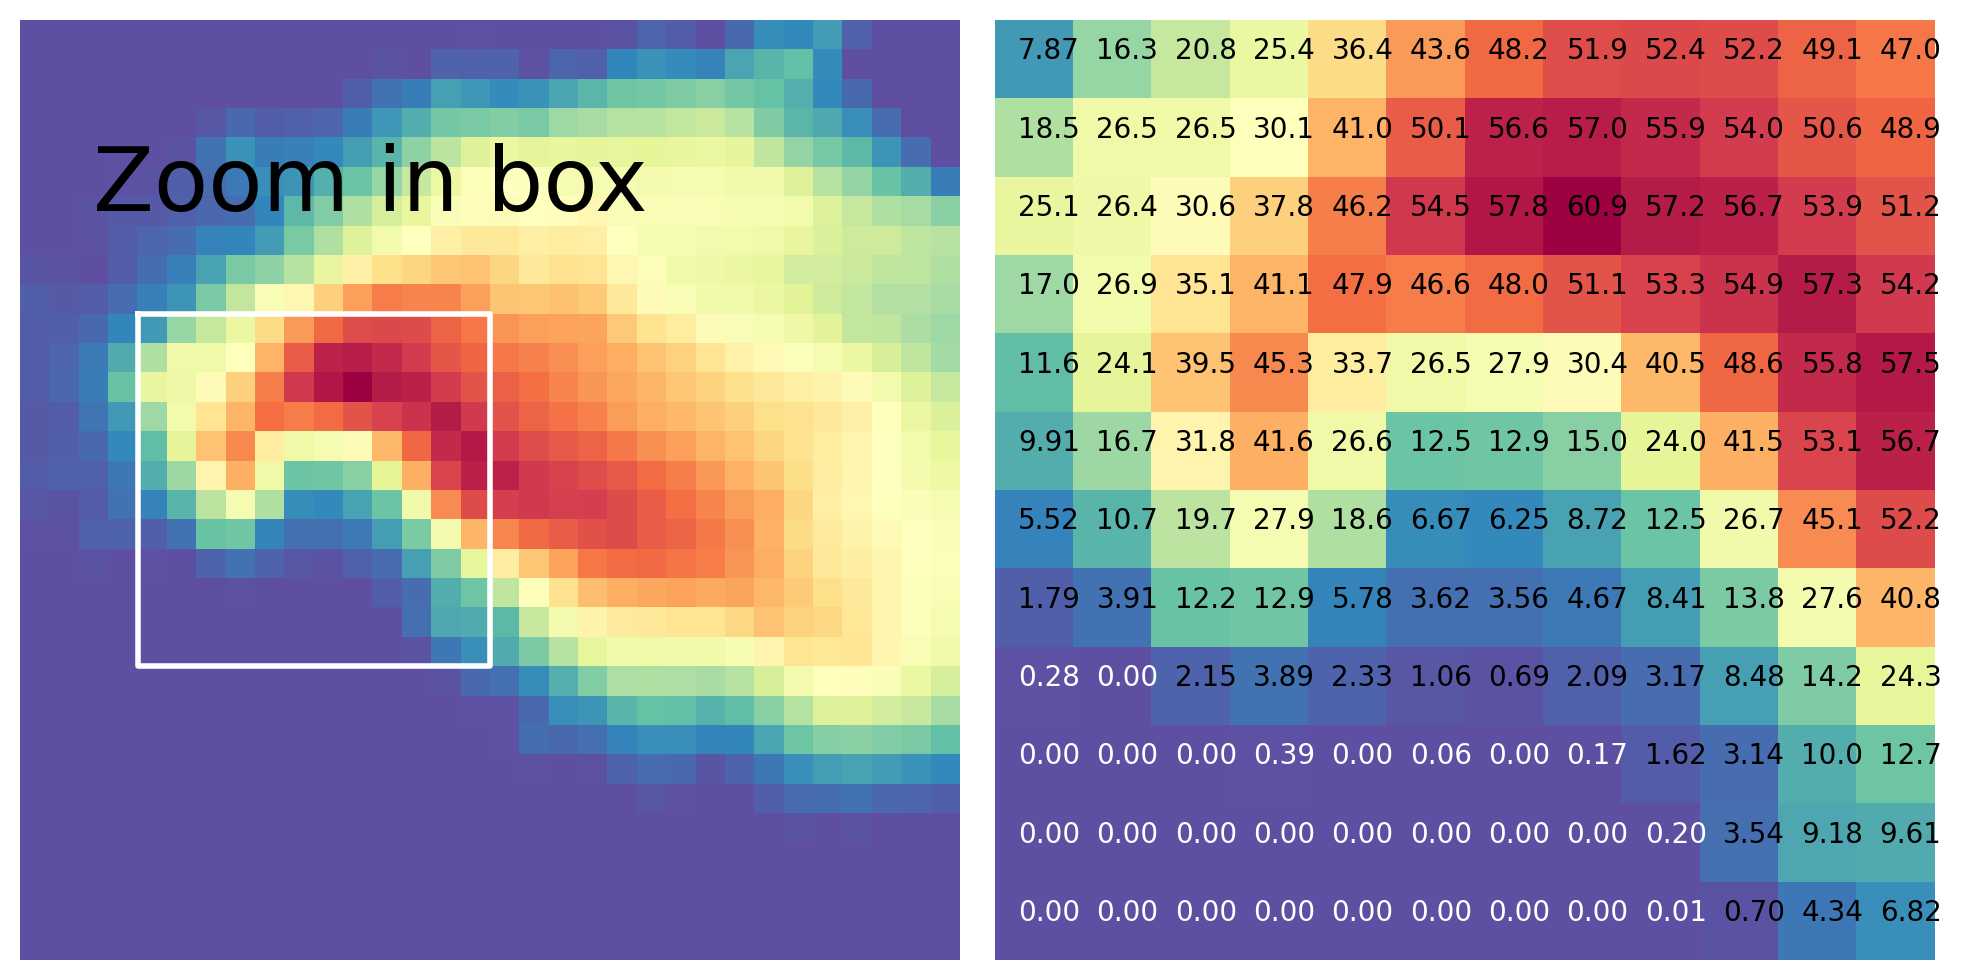

In [3]:
# ユーティリティ関数のインポート
import sys

sys.path.insert(1, "../scripts/")
from aux_functions import show_vals

# 全体を描画
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1 = axes[0]
ax1.imshow(ds_sample.radar_image_matrix[:, :, 0, 0], vmin=0, vmax=60, cmap="Spectral_r")
ax1.axis("off")

# 四角形を描く
x_vertices = np.array([4.0, 16.0, 16.0, 4.0, 4.0])
y_vertices = np.array([10.0, 10.0, 22.0, 22.0, 10.0])
ax1.plot(x_vertices - 0.5, y_vertices - 0.5, "-w", lw=2)
# アノテーションを描く
ax1.text(2, 6, "Zoom in box", color="k", fontsize=32)

# 拡大図
ax2 = axes[1]
da = ds_sample.radar_image_matrix.isel(
    grid_row=slice(10, 22), grid_column=slice(4, 16), radar_height=0, radar_field=0
)
ax2.imshow(da, vmin=0, vmax=60, cmap="Spectral_r")
# ピクセルの値を描画
show_vals(da, ax2)
ax2.axis("off")

fig.tight_layout()

画像が色を表す行列であることが理解できたでしょうか。

次のステップからは、畳み込みの処理過程を一つ一つ確認し CNN で畳み込みがどう使われているのか例を示していきます。


### Step 4: 畳み込みとは？

畳み込みの考えはアニメーションで見ると分かりやすいです。
次の図は論文の図 3 をアニメーションにしたもので、Step 3 で拡大した 12x12 サイズの画像の一部分です。
数学的な定式化はすぐに理解できなくても構いませんが、
カーネル（フィルター）が画像全体を段階的に動いている様子に注目してください。

<center><img src="../images/convolution_animation_01.gif" alt="drawing" width="600"/></center>

畳み込みのイメージがつかめたでしょうか。畳み込みは画像処理技術と考えてもいいでしょう。
数学で説明するならば、畳み込みは演算子です。数学に詳しい人は理解できるでしょうか。

$$p_{x,y} = \sum_{j=y-k}^{j=y+k}\, \sum_{i=x-k}^{i=x+k} w_{i,j} p_{i,j}$$

ここで$p_{x,y}$は画像を行列で表したときの $(x, y)$ での画素値、k はカーネルの大きさです。これを画像中の全画素について繰り返します。

多くの場合、畳み込みカーネルはアニメーションの中央画像で示したカーネルより複雑な重みをもちます。
右の画像は左の画像と同じで周囲に白い縁取りがあるだけだと気づいたでしょうか。
これは、このアニメーションの例では畳み込みの重みに identity カーネルを使っているからです。
行列では次のようになります。

$$
\begin{bmatrix}
0 & 0 & 0  \\ 0 & 1 & 0 \\ 0 & 0 & 0 \\
\end{bmatrix}
$$

このカーネルを拡大した 12x12 サイズの画像に適用すると次のようになります。

<center><img src="../images/sharpen_image.png" alt="drawing" width="600"/></center>

画像全体に適用すると次のようになります。

<center><img src="../images/sharpen_image_full.png" alt="drawing" width="600"/></center>

このカーネルはカーネルの中央の画素を変更せずに通しているだけです。他の一般的なカーネルの場合を見てみましょう。

#### Sharpen

行列

$$\begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix}$$

で表されるカーネルを拡大した部分に適用すると次のようになります。

<center><img src="../images/sharpen_image.png" alt="drawing" width="600"/></center>

画像全体に適用します。

<center><img src="../images/sharpen_image_full.png" alt="drawing" width="600"/></center>

##### Blur (平均)

行列

$$\begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix}$$

で表されるカーネルを拡大した部分に適用すると次のようになります。

<center><img src="../images/blur_image.png" alt="drawing" width="600"/></center>

画像全体に適用します。

<center><img src="../images/blur_image_full.png" alt="drawing" width="600"/></center>

その他多くのカーネルの例が [Wikipedia](<https://en.wikipedia.org/wiki/Kernel_(image_processing)>) にあります。


#### Step 5：畳み込みの実装

畳み込み演算を自分で実装することもできますが、PyTorch には畳み込み層のクラス `torch.nn.Conv2d` が用意されています。

重みははじめランダムに初期化されているので適当な重みをカーネルとして使うように畳み込み層に設定する必要があります。重みは簡単に変更できます。


(-0.5, 33.5, 33.5, -0.5)

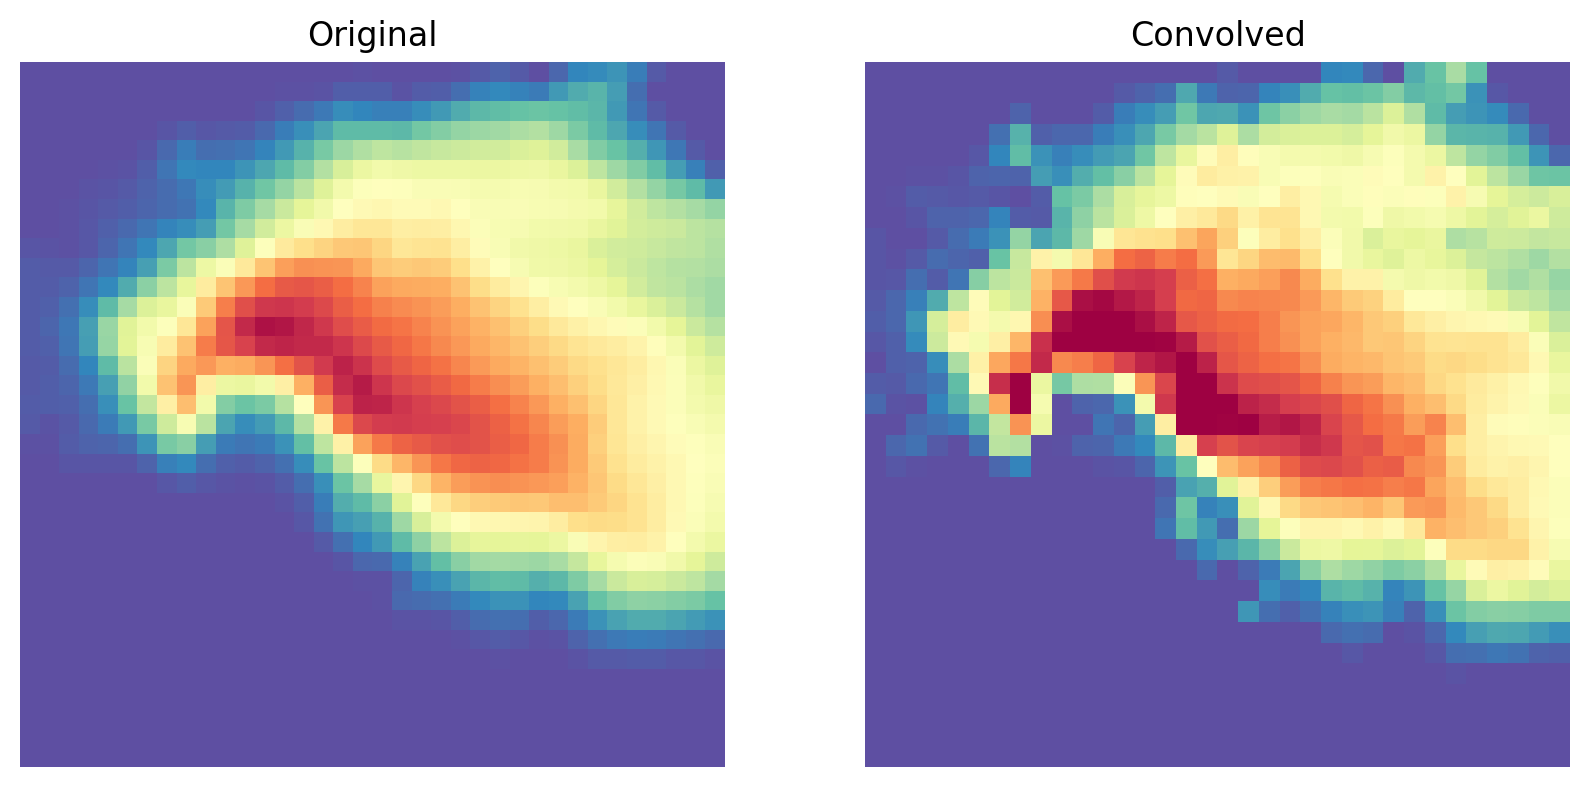

In [4]:
import torchvision.transforms.functional as F

# レーダー画像データ: 次元は (row, columns, height)
da = ds_sample.radar_image_matrix.isel(radar_height=slice(0, 1), radar_field=0)
# PyTorchのデータは (batch, channels, height, width) で扱うので次元を入れ替える
# row と column が逆でも本質的な違いはないので height 次元だけ入れ替える
da_values = torch.tensor(da.values.transpose(2, 0, 1))

# 36x36サイズに切り出す
more_points = F.resize(da_values, [36, 36], antialias=False)

# sharpen フィルターの定義
kernel_weights = torch.FloatTensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

# 畳み込み層のモデル定義
conv = nn.Conv2d(
    in_channels=1,  # 入力チャネル数
    out_channels=1,  # 出力チャネル数
    kernel_size=3,  # カーネルサイズ
    bias=False,  # バイアス項を含めるかどうか
)

# モデルに重みを設定: 次元は (B, C, H, W) でないといけないので追加する
# Noneを指定するとnp.newaxis相当になる
conv.weight = nn.Parameter(kernel_weights[None, None, :, :])

# 畳み込みの適用
with torch.no_grad():
    res = conv(more_points)
res = res.detach().numpy()

# プロット
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(more_points[0, :, :], vmin=0, vmax=60, cmap="Spectral_r")
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(res[0, :, :], vmin=0, vmax=60, cmap="Spectral_r")
ax2.set_title("Convolved")
ax2.axis("off")

畳み込みを行うだけなら `np.convolve` を使う方が簡単ですが CNN で利用するので `nn.Conv2d` の使い方に慣れておきましょう。


### ステップ 6：別の画像で試してみる

畳み込みに慣れるためのオンラインの画像を使って遊びながら練習してみましょう。
オンラインから好きな画像の URL を探して `url` 変数にコピー＆ペーストします。
このコードを実行するとその画像に対して畳み込みを実行します。

この例では AI2ES のロゴを取得して畳み込みによりぼかしています。重みをいろいろ変えて畳み込みにどう影響するのか試してみましょう。


(-0.5, 257.5, 257.5, -0.5)

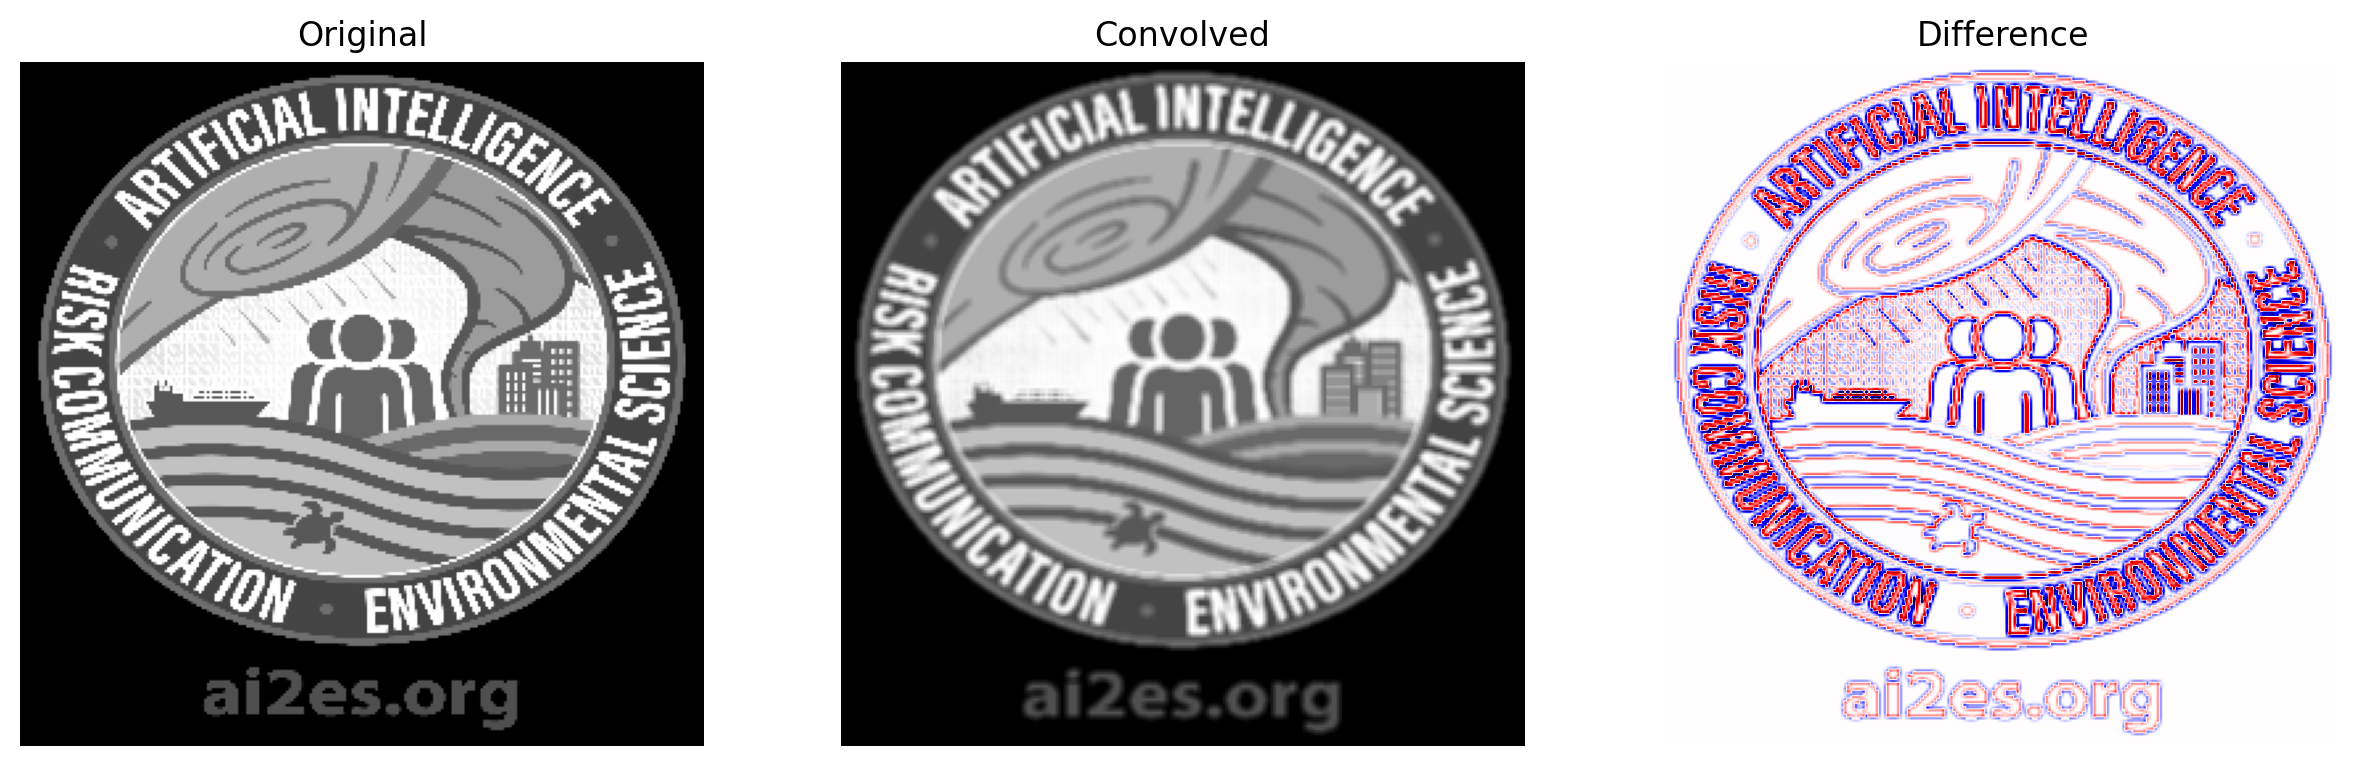

In [5]:
# ここに好きな画像のURLをコピー＆ペーストしてみましょう
url = "https://dopplerchase-ai2es-schooner-hpc.readthedocs.io/en/latest/_images/ai2es-logo-web-trans.png"

from io import BytesIO

from PIL import Image, ImageOps
import requests
import torchvision.transforms.functional as F

# 画像データの取得
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = ImageOps.grayscale(img)
arr = np.array(img.convert("F"))
arr = torch.tensor(arr)[None, ...]

# 260x260サイズに切り出す
arr = F.resize(arr, [260, 260], antialias=False)

# blur フィルターの定義
kernel_weights = torch.FloatTensor([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) * (1 / 9.0)

# 畳み込み層のモデル定義
conv = nn.Conv2d(
    in_channels=1,  # 入力チャネル数
    out_channels=1,  # 出力チャネル数
    kernel_size=3,  # カーネルサイズ
    bias=False,  # バイアス項を含めるかどうか
)

# モデルに重みを設定: 次元は (B, C, H, W) でないといけないので追加する
conv.weight = nn.Parameter(kernel_weights[None, None, ...])

# 畳み込みの適用
with torch.no_grad():
    res = conv(arr[None, ...])
res = res.detach().numpy()

# プロット
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), facecolor="w")

ax1.imshow(arr[0], vmin=0, vmax=255, cmap="Greys_r")
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(res[0, 0, :, :], vmin=0, vmax=255, cmap="Greys_r")
ax2.set_title("Convolved")
ax2.axis("off")

# 差分（両端が1サイズ小さくなっていることに注意）
ax3.imshow(arr[0, 1:-1, 1:-1] - res[0, 0, :, :], vmin=-100, vmax=100, cmap="seismic")
ax3.set_title("Difference")
ax3.axis("off")

次はカウボーイの画像です。


(-0.5, 257.5, 257.5, -0.5)

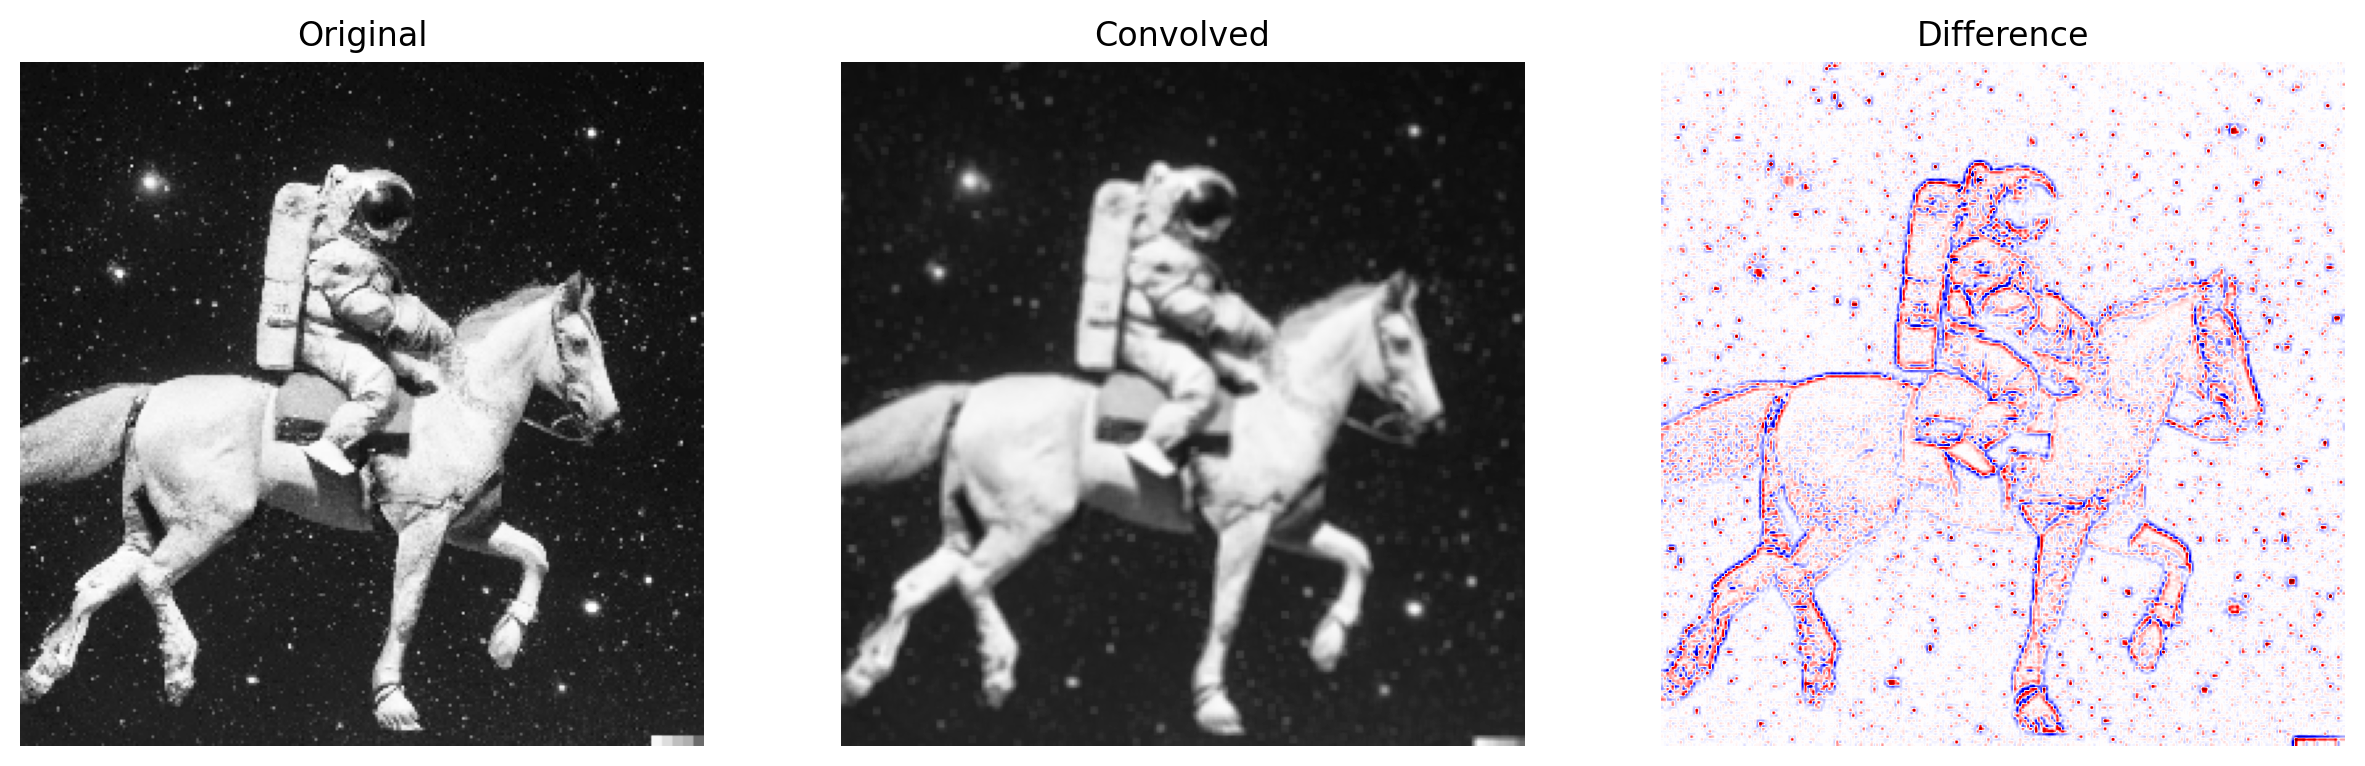

In [6]:
# ここに好きな画像のURLをコピー＆ペーストしてみましょう
url = "https://cdn.openai.com/dall-e-2/demos/text2im/astronaut/horse/photo/0.jpg"

from PIL import Image, ImageOps
import requests
from io import BytesIO

# 画像データの取得
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = ImageOps.grayscale(img)
arr = np.array(img.convert("F"))
arr = torch.tensor(arr)[None, ...]

# 260x260サイズに切り出す
arr = F.resize(arr, [260, 260], antialias=False)

# blur フィルターの定義
kernel_weights = torch.FloatTensor([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) * (1 / 9.0)

# 畳み込み層のモデル定義
conv = nn.Conv2d(
    in_channels=1,  # 入力チャネル数
    out_channels=1,  # 出力チャネル数
    kernel_size=3,  # カーネルサイズ
    bias=False,  # バイアス項を含めるかどうか
)

# モデルに重みを設定: 次元は (B, C, H, W) でないといけないので追加する
conv.weight = nn.Parameter(kernel_weights[None, None, ...])

# 畳み込みの適用
with torch.no_grad():
    res = conv(arr[None, ...])
res = res.detach().numpy()

# プロット
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), facecolor="w")

ax1.imshow(arr[0], vmin=0, vmax=255, cmap="Greys_r")
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(res[0, 0, :, :], vmin=0, vmax=255, cmap="Greys_r")
ax2.set_title("Convolved")
ax2.axis("off")

# 差分（両端が1サイズ小さくなっていることに注意）
ax3.imshow(arr[0, 1:-1, 1:-1] - res[0, 0, :, :], vmin=-100, vmax=100, cmap="seismic")
ax3.set_title("Difference")
ax3.axis("off")

### Step 7: パディング

畳み込みのアニメーション画像をもう一度見てみましょう。両端に注目してください。

<center><img src="../images/convolution_animation_01.gif" alt="drawing" width="600"/></center>

画像の周りがデータのない境界線になっているのが分かるでしょうか？これはバグではありません。
この畳み込みカーネルは中央のピクセルの左右上下のデータを処理します。
画像の端では中央のピクセルの上下左右の少なくとも一部はデータが存在せずカーネルがピクセルを処理できません。
カーネルは端のピクセルの処理をスキップするため出力される画像は入力より小さくなります。つまり、畳み込みにより画像の解像度（ピクセルサイズ）は小さくなります。

端のピクセルが失われないようにするために **パディング** という手法があります。
畳み込みの出力が元の画像と同じ形状になるように _入力_ する画像の端に値 0 のデータを足し合わせます。次のコードブロックは画像の周りに 0 パディングを追加する処理です。


(-0.5, 13.5, 13.5, -0.5)

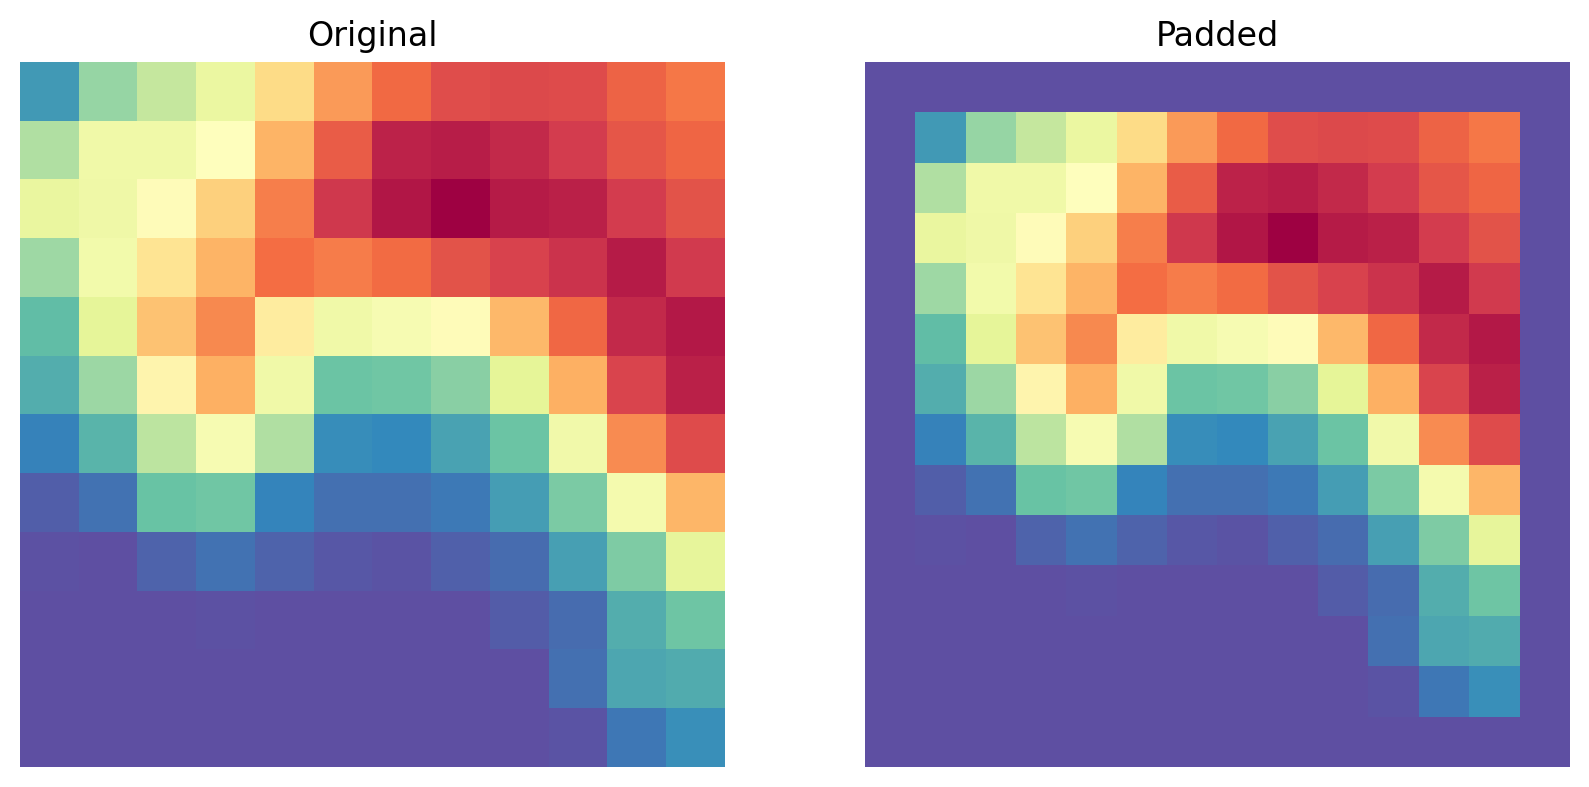

In [7]:
import copy

import torchvision.transforms.functional as F

# 入力画像
da = ds_sample.radar_image_matrix.isel(
    grid_row=slice(10, 22), grid_column=slice(4, 16), radar_height=0, radar_field=0
)
# 次元を (C, H, W) にする
Z_old = torch.tensor(copy.deepcopy(da.values))

# パディング、(1次元目の左右, 1次元目の上下, 2次元目の左右, ...) のタプルで指定する
Z = F.pad(Z_old, padding=(1, 1, 1, 1), fill=0, padding_mode="constant")

# プロット
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(Z_old, vmin=0, vmax=60, cmap="Spectral_r")
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(Z, vmin=0, vmax=60, cmap="Spectral_r")
ax2.set_title("Padded")
ax2.axis("off")

パディングを行った場合の畳み込みのアニメーションを見てみましょう。元の画像のサイズが保たれていることが分かります。

<center><img src="../images/convolution_animation_01_padded.gif" alt="drawing" width="600"/></center>

PyTorch では `nn.Conv2d` クラスで `padding="same"` とすることで元の画像サイズが保たれるようにパディングすることができます。


(-0.5, 35.5, 35.5, -0.5)

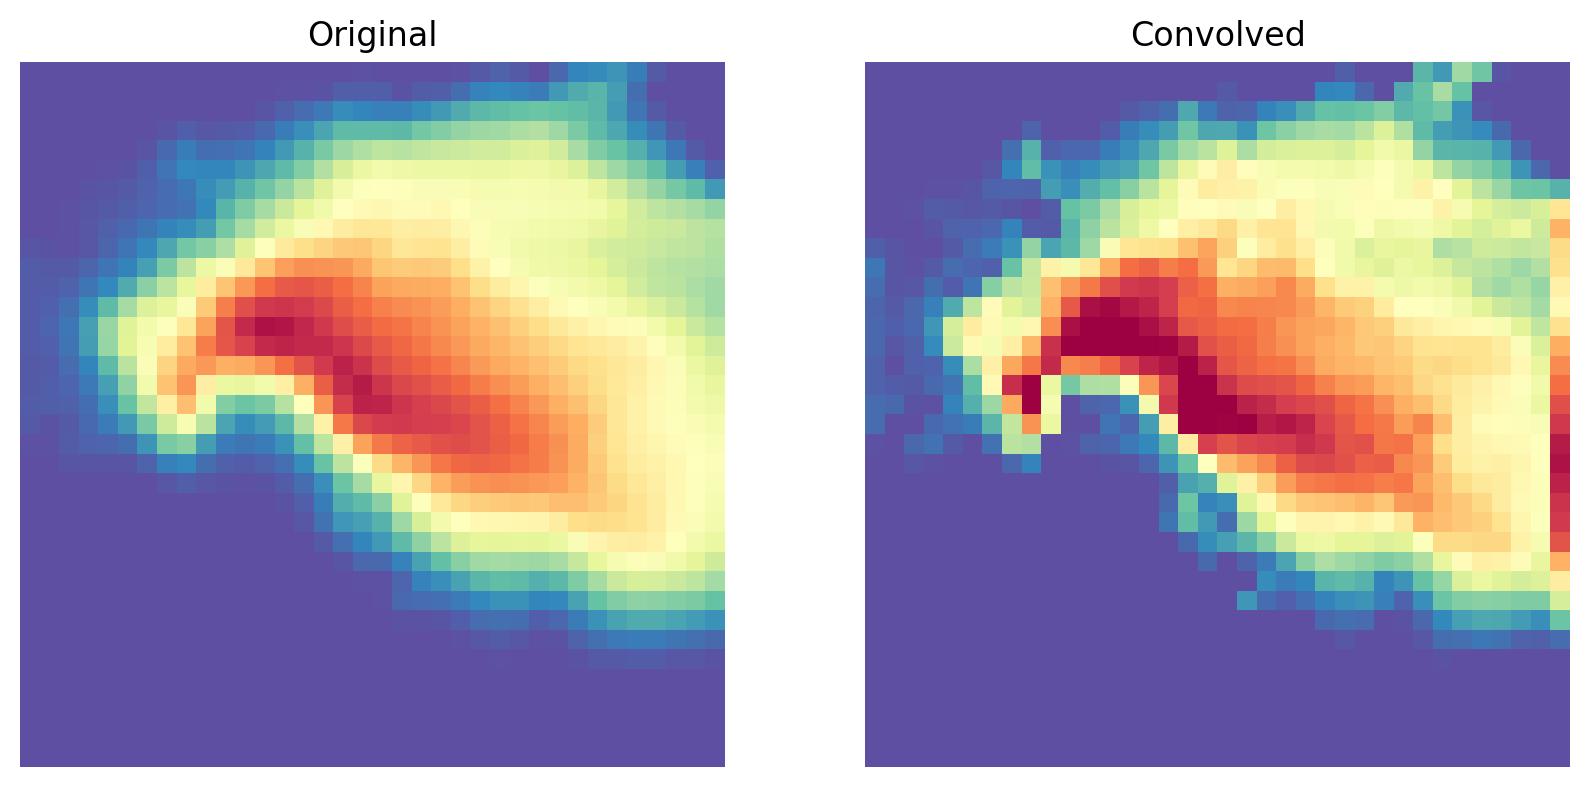

In [8]:
# 36x36サイズに切り出す
da = ds_sample.radar_image_matrix.isel(radar_height=slice(0, 1), radar_field=0)
da_values = torch.tensor(da.values.transpose(2, 0, 1))
more_points = F.resize(da_values, [36, 36], antialias=False)

# sharpen filter の定義
kernel_weights = torch.FloatTensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

# 畳み込み層のモデル定義
conv = nn.Conv2d(
    in_channels=1,  # 入力チャネル数
    out_channels=1,  # 出力チャネル数
    kernel_size=3,  # カーネルサイズ
    bias=False,  # バイアス項を含めるかどうか
    padding="same",
)

# モデルに重みを設定: 次元は (B, C, H, W) でないといけないので追加する
conv.weight = nn.Parameter(kernel_weights[None, None, :, :])


# 畳み込みの適用
with torch.no_grad():
    res = conv(more_points)
res = res.detach().numpy()

# プロット
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(more_points[0, :, :], vmin=0, vmax=60, cmap="Spectral_r")
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(res[0, :, :], vmin=0, vmax=60, cmap="Spectral_r")
ax2.set_title("Convolved")
ax2.axis("off")

右の画像の右端に赤い（=値が大きい）線があることに注目してください。
これはパディングの影響です。特にシャープフィルターはカーネルを適用する 3x3 ピクセルのうち半分のピクセルが 0 になってしまうと望ましくない振る舞いをする可能性があります。

この結果には戸惑うかもしれませんがまだ機械学習を行っているわけではありません。
これから機械学習に畳み込みを適用する場合にシャープフィルターは雷雲の分類に最適な選択ではないのかもしれません。

次のノートではこのノートで学んだことを応用して `sub-sevir`データセットを使って雷を検出する CNN を学習します。
